# Project Modeling

Name: Edward Chen  
Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2021  
Instructor: Prof. Brian King

### In this notebook:
* I will introduce the **machine learning method** that I used for this classification problem.
* Load and Preprocess the Chest X-rays Datasets
* Extract a Smaller Subset of Datasets for Testing and Tuning CNN Architectures 
* CNN Architecture 1: **ResNet 50-Layer** [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* Train and Test the ResNet 50-Layer using a 80/20 (train/test) split
* 5-Fold Cross Validation of ResNet 50-Layer on the Subset
* CNN Architecture 2: **DenseNet 121-Layer** [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)
* Train and Test the DenseNet 121-Layer using a 80/20 (train/test) split
* 5-Fold Cross Validation of DenseNet 121-Layer on the Subset
* 5-Fold Grid Search on set of parameters: models (ResNet 50 or DenseNet 121), Learning Rate, and Train Batch Size
* 5-Fold Cross Validation of DenseNet 121-Layer on the Whole Dataset
* Statistics of the Performance
* Compare to the Human Experts
* Visualizing the Features Outputs (Low-level to High-level) from a Trained DenseNet 121 model

### 1. Import the Libraries

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy import interp

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.utils.data import ConcatDataset

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, densenet121

import sklearn
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold, StratifiedKFold, ParameterGrid
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import seaborn as sns

import ast
import pickle

import time
tic, toc = (time.time, time.time)

In [2]:
print("Matplotlib:")
print(matplotlib.__version__)
print("\nNumPy:")
print(np.__version__)
print("\ntorch:")
print(torch.__version__)
print("\ntorchvision:")
print(torchvision.__version__)
print("\nScikit-learn:")
print(sklearn.__version__)
print("\nPandas:")
print(pd.__version__)
print("\nSeaborn:")
print(sns.__version__)

Matplotlib:
3.2.2

NumPy:
1.19.1

torch:
1.7.0

torchvision:
0.8.1

Scikit-learn:
0.23.2

Pandas:
1.1.4

Seaborn:
0.10.1


### 2. Introduce to the Method: Convolutional Neural Network (CNN)

#### What is a convolutional neural network?
Convolutional neural network (CNN) is a **regularized deep neural network**. Similarly to the fully connected neural networks, they use the **feed forward** and **gradient descent** in tuning its model's weights. However, as a regularized deep neural network, CNN can be applied to the **data with high-dimensionality** using the **partially connected layers** (e.g. layers of spatial filters) and **convolutions** (math operations). Thus, CNN can be applied to the **problems with high-dimensional spaces**, such as image classification, segmentation, audio, and video recognition.

#### How is CNN regularized?
Convolutional neural network takes advantage of the **spatial coherence** (see [section 12 of DataPrep_EDA](DataPrep_EDA.ipynb)) presented in the data to reduce the network's redundant parameters with **partially connected layers** and **convolution**.

For illustration, assume we have an input image with shape $32 \times 32$ (height x width = $1024$ pixels). If we decide to feed it into a hidden layer of $16 \times 16$ neurons ($256$ neurons) in a fully connected neural network. Then, each neuron will connect to every pixel in the input image. A neuron will have $32 \times 32$ weights (in-connections) $+ 1$ bias. The hidden layer will then have $(32 \times 32 + 1) \times 16 \times 16 = 262,400$ weights and bias in total.

However, as we discussed in the [section 12 of DataPrp_EDA](DataPrep_EDA.ipynb), the values of **spatially adjacent** pixels are **strongly correlated**. The fully connected layer will hence create many **redundant** connections. To prune the redundant parameters, we want **every neuron** to connect with **only one** spatially adjacent **group of pixels** (e.g. a **3 x 3** region). 

Therefore, by taking advantage of the data's spatial coherence, we reduce the number of weights from $(32 \times 32 + 1) \times 16 \times 16 = 262,400$ to $(3 \times 3 + 1) \times 16 \times 16 = 2560$ (**~1%** of the original).

<figure class="image">
    <img src="https://www.researchgate.net/profile/Eftim-Zdravevski/publication/327765620/figure/fig3/AS:672852214812688@1537431877977/Fully-connected-neural-network-vs-convolutional-neural-network-with-filter-size-1-2_W640.jpg" width="200" height="" />
    <figcaption>Fig 1. Fully connected layer (above) vs. Partially and locally connected layer (below). [1]</figcaption>
</figure>

Furthermore, as we discussed in the end of [section 18 of DataPrep_EDA](DataPrep_EDA.ipynb), **some features** in the images are **more important** for the analysis than the other general patterns. Therefore, instead of having $16 x 16$ different neurons, we reduce them to only **one neuron** with weights $=3 x 3$. The neuron will act as a **learnable spatil filter** (see [section 19 of DataPrp_EDA](DataPrep_EDA.ipynb)) that convolutes across the image. The output will hence be **a map of a specific spatial feature** which the neuron/filter biases on. 

<figure class="image">
    <img src="https://mlnotebook.github.io/img/CNN/convSobel.gif" width="400" height="" />
    <figcaption>Fig 2. Filter convolutes across the input image and produce a feature map [3]. Notice that the filter is a Sobel-y filter that detects change in y-direction.</figcaption>
</figure>

However, analysis may certainly **need more than one type of features** from the input image. To increase the number of features learned by the filter, we **increase the depth of filter**. You can also think this as **appending more matrices** (spatial filter with depth 1) to the filter. Each depth of filter will convolute across the image and produce a map of feature. If we decided to extract **16 different features** from an input $32 x 32$ image, we will end up having $(3 \times 3 + 1) \times 16 = 160$ weights and bias (**only 0.06%** of the original).

If the image or input feature maps from previous layer **contains more than one channel of information** (e.g. RGB color image), the filter will **replace the numeric value** inside each cell of matrices to **a vector** whose length is the number of channels/depth of the input.

Thus, the general formular for the number of weights and bais inside a convolutional layer is:
$$[(\text{ Height}_{filter} \times \text{Width}_{filter} \times \text{Depth}_{input} + 1)] \times \text{Depth}_{output} $$

By introducing **additional convolutional layers**, CNN will be able to capture the **hierarchical features** (low-level details to high-level patterns) in the data. CNN can be further pruned using max pooling and dropout layers.

References:  
[1] Albawi, S. et al., "Understanding of a Convolutional Neural Network", [https://www.researchgate.net/publication/319253577_Understanding_of_a_Convolutional_Neural_Network](https://www.researchgate.net/publication/319253577_Understanding_of_a_Convolutional_Neural_Network)  
[2] Stojov, V. et al., "Application of machine learning and time-series analysis for air pollution prediction", [https://www.researchgate.net/publication/327765620_Application_of_machine_learning_and_time-series_analysis_for_air_pollution_prediction](https://www.researchgate.net/publication/327765620_Application_of_machine_learning_and_time-series_analysis_for_air_pollution_prediction)  
[3] Phillips, T., "Exercise Classification with Machine Learning (Part II)", [https://towardsdatascience.com/exercise-classification-with-machine-learning-part-ii-d60d1928f31d](https://towardsdatascience.com/exercise-classification-with-machine-learning-part-ii-d60d1928f31d)

---

### 3. Make the CXR Dataset Using ImageFolder with Transformations
In this notebook, we will use the features extarctor of **pretrained deep learning models**, which are tuned on the [ImageNet](https://www.image-net.org/) Dataset, a large visual recognition dataset that contains millions of images of an object from thousands of categories. 

The **pretrained deep learning models** (e.g. [ResNet 50](https://pytorch.org/hub/pytorch_vision_resnet/)) expects the input images to:  
* be a 3-channel RGB images
* with width >= 224 pixels and height >= 224 pixels
* be first loaded in to a range of `[0, 1]`
* then normalized with mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]` (3-channel (R, G, B)).

Therefore, in the `ImageFolder` dataset below, we will apply the transformations: 
1. transforms.Resize((256, 256)): **Resize** the image into size (height=256, width=256).
2. transforms.ToTensor(): Convert the PIL image to a torch.Tensor Object
3. MinMaxNorm(): **Normalize** the Tensor Image **to range of `[0, 1]`** using Min-Max normalization
4. transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)): **Normalize** the image with mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]`

Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ../data/COVID-19_Radiography_Dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               MinMaxNorm(): Normalize the tensor image to range [0, 1]
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

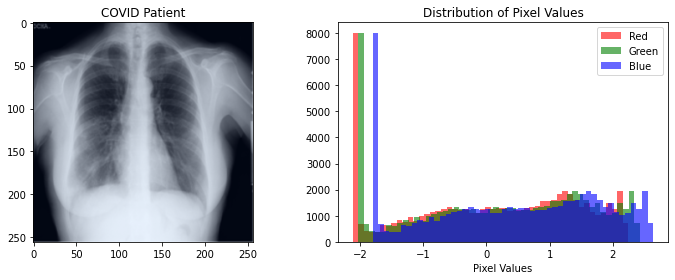

In [3]:
class MinMaxNorm(object):
    """
    MinMax Normalization
    Normalize the image to a range of [0, 1]
    """
    def __call__(self, tensor_image):
        """
        :param tensor_image: The tensor image that will be normalized
        :type tensor_image: torch.Tensor
        :return: a MinMax normalized tensor image
        :rtype: torch.Tensor
        """
        tensor_image -= tensor_image.min()
        tensor_image /= tensor_image.max()
        
        return tensor_image
    
    def __repr__(self):
        return self.__class__.__name__+'(): Normalize the tensor image to range [0, 1]'

    
# Load the Whole dataset
data_xrays = ImageFolder('../data/COVID-19_Radiography_Dataset/', 
                       transform=transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           MinMaxNorm(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                       ]))

display(data_xrays)

# Mannually set up the seed for numpy module (Reproducibility)
np.random.seed(0)
rand_idx = np.random.randint(len(data_xrays))

# Randomly Sampled out an Image for visualization
sampled_image, target_idx = data_xrays[rand_idx]

# To plot the image we need transform the image's shape from
# [Channel x Height x Width] to [Height x Width x Channel]
sampled_image = sampled_image.numpy().transpose([1, 2, 0])
# And MinMax normalize the image
plotable_image = sampled_image - sampled_image.min()
plotable_image /= plotable_image.max()

# Name of image's class
class_name = data_xrays.classes[target_idx]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title("{:s} Patient".format(class_name))
ax[0].imshow(plotable_image)

# Histogram of image's RGB values
ax[1].set_title("Distribution of Pixel Values")
ax[1].hist(sampled_image[..., 0].ravel(), label="Red", color='r', alpha=0.6, bins=50)
ax[1].hist(sampled_image[..., 1].ravel(), label="Green", color='g', alpha=0.6, bins=50)
ax[1].hist(sampled_image[..., 2].ravel(), label="Blue", color='b', alpha=0.6, bins=50)
ax[1].set_xlabel("Pixel Values")

plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

### 4. Load a Smaller Subset of Datasets (2500 Images) into DataLoader
We will use a **smaller subset, 2500 images**, of the whole dataset, 22165 images, for testing and tuning the deep learning models. To make the subset a good approximation of the whole dataset, we will **preserve the original ratios** between classes in the subset. To achieve this, we will specifiy the `stratify` argument to be the class labels of samples in the `train_test_split` function. 

We will perform a **80/20 train/test** split on the sampled subset. The **train** dataset will have **2000** Chest X-ray images, and the **test** dataset will have the rest **500** images.

The train and test dataset will be loaded into DataLoader objects with batch size of 128. In the subsequent cells, we will train and test two deep learning architectures on this pre-split dataset.

In [4]:
class_names = data_xrays.classes

# If you have out of memory error, you may wish to scale down the batch_size
# Spec: This notebook is running on a RTX2080 Ti with 14 GB of graphic memory.
train_batch_size = 128
test_batch_size = 128

test_data_size = 500
train_data_size = int(test_data_size * 4)

np.random.seed(0)
torch.manual_seed(0)

train_indices, test_indices = model_selection.train_test_split(np.arange(len(data_xrays.samples)), 
                                                               random_state=0,
                                                               test_size=test_data_size, 
                                                               train_size=train_data_size,
                                                               stratify=data_xrays.targets)

trainData = torch.utils.data.Subset(data_xrays, train_indices.tolist())
testData = torch.utils.data.Subset(data_xrays, test_indices.tolist())

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(trainData,
    batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(testData,
    batch_size=test_batch_size, shuffle=True, **kwargs)

When we test and train the deep neural networks, using a smaller subset can **save lots of time** and allow us to **explore more sets of hyper-parameters**. At the same time, the results from subset will still be a **good approximation** of network's performance **on the whole dataset** if we carefully choose the subset. In our case, we need to preserve the class ratio of this imbalanced dataset in its subset.

### 5. Check the Number of Instances per Class in Subset: Perserving Class Ratios
We want to make sure the **ratios between classes are preserved** in the smaller subset. 

In this cell, we will count the number of instances from each class and the ratios of each class in the whole dataset and subset. We will also plot the counts of class instances for the whole dataset and subset as histogram.

Class to Index correspondence


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

Whole Dataset

Classes        : Counts   ratio % of whole Dataset
COVID          :   3616   17.08 %
Lung_Opacity   :   6012   28.41 %
Normal         :  10192   48.15 %
Viral Pneumonia:   1345    6.35 %
Total          :  21165

Subset Dataset

Classes        : Counts   ratio % of Subset
COVID          :    427   17.08 %
Lung_Opacity   :    710   28.40 %
Normal         :   1204   48.16 %
Viral Pneumonia:    159    6.36 %
Total          :   2500



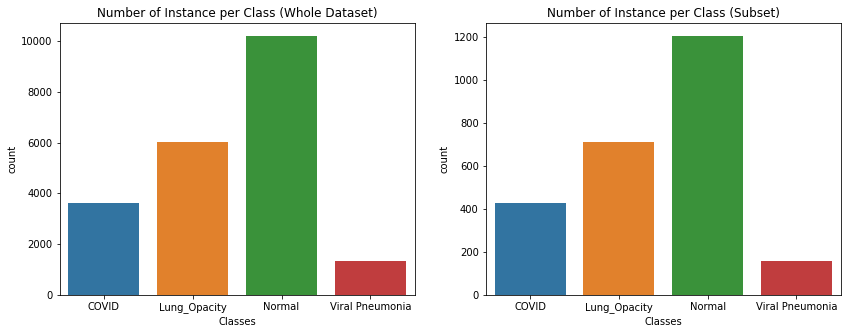

In [5]:
print("Class to Index correspondence")
display(data_xrays.class_to_idx)

# Class counts of the whole dataset
classes, class_counts = np.unique(data_xrays.targets, return_counts=True)
data_targets = data_xrays.targets.copy()

print("Whole Dataset")
print("\n{:15s}: Counts   ratio % of whole Dataset".format("Classes"))
for i in range(len(data_xrays.classes)):
    print("{:15s}: {:6d}   {:5.2f} %"
          .format(data_xrays.classes[i], class_counts[i], 
                  class_counts[i] / np.sum(class_counts) * 100))
print("{:15s}: {:6d}\n".format("Total", np.sum(class_counts)))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the count plot of class instances in the whole set
ax[0].set_title("Number of Instance per Class (Whole Dataset)")
ax[0].set_xlabel("Classes")

targets_with_class_name = [data_xrays.classes[x] for x in data_targets]
sns.countplot(targets_with_class_name, order=data_xrays.classes, ax=ax[0])

# Class counts of the subset
subset_targets = np.array(data_xrays.targets)[train_indices.tolist() + test_indices.tolist()]
subset_classes, subset_class_counts = np.unique(subset_targets, return_counts=True) 

print("Subset Dataset")
print("\n{:15s}: Counts   ratio % of Subset".format("Classes"))
for i in range(len(data_xrays.classes)):
    print("{:15s}: {:6d}   {:5.2f} %"
          .format(data_xrays.classes[i], subset_class_counts[i], 
                  subset_class_counts[i] / np.sum(subset_class_counts) * 100))
print("{:15s}: {:6d}\n".format("Total", np.sum(subset_class_counts)))

# Plot the count plot of class instances in the subset
targets_with_class_name_subset = [data_xrays.classes[x] for x in subset_targets]
sns.countplot(targets_with_class_name_subset, order=data_xrays.classes, ax=ax[1])

ax[1].set_title("Number of Instance per Class (Subset)")
ax[1].set_xlabel("Classes")

plt.show()

### 6. Utility Functions: Train and Test Functions for the Pytorch Models 
In this cell, I will define **four helper functions** for training and testing the convolutional neural network and visualzing the train & test history.

`train_val_model()`: Train and test a pytorch model using the given train & test datasets, optimizer, loss function, etc. The functions will return the train loss, train accuracy, test loss, test accuracy, train results (truth, pred) at epoch with minimum loss, and test results (truth, pred) at epoch with minimum loss.

`train()`: Train the giving model with the train dataset for one epoch. This function will be called internally by the `train_val_model()`.

`test()`: Test the giving model with the test dataset. This function will be called internally by the `train_val_model()`.

`plot_train_val_stats()`: Plot the train and testing history of the model using the outputs from the `train_val_model()`.

If you wish to know more details about these helper functions, please check their doc strings below.

#### 6.1 Why did I write my own helper fucntions for training and testing Pytorch Models?
1. Pytorch **does not** provide a classifier wrapper (like KerasClassifier) for its deep learning models.
2. In this project, I will use **pretrained deep learning models**. Only a subset of pretrained model's weights will be adjusted in the training. Writing my own helper functions will give me **more flexibility** in defining the training and testing on pretarined models.

#### 6.2 Why I did not use the Pytorch's Scikit-Learn wrapper, [skorch](https://github.com/skorch-dev/skorch)?
Skorch provides a Pytorch classifier wrapper that is similar to the keras's KerasClassifier. However, I have two major concerns in using this wrapper package, [skorch](https://github.com/skorch-dev/skorch).

1. skorch is **an incomplete wrapper** for the Pytorch. Tasks, such as image classification, cannot be done easily using the skorch alone. For example, skorch does not provide wrapper for the Pytorch's Image Dataset, such as ImageFolder. See skorch's [Issue #443](https://github.com/skorch-dev/skorch/issues/443) Though @BenjaminBossan provides a solution for this at the end, **lack of wrappers for the frequently used functionalities** undermine the benefits of using skorch.
2. skorch is neither maintained by the pytorch or as a part of the scikit-learn package, and pytorch is not in its dependencies. Thus, we don't know which version of pytorch is the skorch tested on. This greatly **undermines the reliability of skorch** (See [Issue #666](https://github.com/skorch-dev/skorch/issues/666#issuecomment-660302743)).

One desirable quality of a good medical research is the **reproducibility**. Using my own helper functions provides me the (no guaranteed but) maximum reproducibility of my methods. 

In [6]:
def train_val_model(model, train_loader, test_loader, 
                    optimizer, loss_func, device, max_epoch=30,
                    class_names=None, train_report=False, train_verbose=25,
                    test_report=True, save_model=False, saved_model_path="best_model.pth",
                    return_raw_outputs=False):
    """
    :param model: pytorch model (class:torch.nn.Module)
    :param train_loader: torch.utils.data.DataLoader of train dataset
    :param test_loader: torch.utils.data.DataLoader of test dataset
    :param optimizer: optimizer for the model
    :param loss_func: loss function for the training
    :param device: device used to train the model (e.g. torch.device("cuda") for training on GPU)
    :param max_epoch: maximum number of epochs for training this model
    :param class_names: str Name for the classification classses. used in train report
    :param train_report: whether to print a classification report of training after each epoch
    :param train_verbose: print a train progress report after how many batches of training in each epoch
    :param test_report: whether to print a classification report of testing after each epoch
    :param save_model: whether to save the model with minimum test loss
    :param saved_model_path: the str path for the saved model
    :param return_raw_outputs: whether return the raw outputs of model (before argmax). used for auc computation
    :return: train loss, train accuracy, test loss, test accuracy, train results (truth, pred) at epoch with minimum loss, \
    test results (truth, pred) at epoch with minimum loss
    """
    test_loss = []
    test_acc = []
    train_loss = []
    train_acc = []
    
    # The train test results of the epoch in which test loss is minimum
    ret_train_results = None
    ret_test_results = None
    
    # Set the minimum loss to be very large at the start
    min_loss = 1e6
    
    for epoch in range(1, max_epoch + 1):
        print("-" * 30 + "EPOCH{:3d}".format(epoch) + "-" * 30)

        # Get the train results from training of each epoch
        train_results = train(model, device, train_loader, optimizer, 
                        epoch, loss_func, 
                        class_names=class_names, report=train_report, verbose_interval=train_verbose)
        
        train_loss.append(train_results[0])
        train_acc.append(train_results[1])

        test_results = test(model, device, test_loader, loss_func,
                            class_names=class_names, report=test_report,
                            return_raw_outputs=return_raw_outputs)

        # If save the model with best test loss
        if save_model and (min_loss > test_results[0]):
            torch.save(model.state_dict(), saved_model_path)
            min_loss = test_results[0]
            
        # Save the train and test results if the test loss is a new minimum
        if (min_loss > test_results[0]):
            ret_train_results = train_results[2:]
            ret_test_results = test_results[2:]
            min_loss = test_results[0]
        
        test_loss.append(test_results[0])
        test_acc.append(test_results[1])
        
    # Just in case if the test loss is huge and never go down to the initial minimum 
    if ret_test_results is None:
        # This should not happen in most cases
        ret_train_results = train_results[2:]
        ret_test_results = test_results[2:]
        
    return train_loss, train_acc, test_loss, test_acc, ret_train_results, ret_test_results


def train(model, device, train_loader, optimizer, epoch, loss_func, 
          class_names=None, report=False, verbose_interval=25):
    """
    :param model: pytorch model (class:torch.nn.Module)
    :param device: device used to train the model (e.g. torch.device("cuda") for training on GPU)
    :param train_loader: torch.utils.data.DataLoader of train dataset
    :param optimizer: optimizer for the model
    :param epoch: current epoch of training
    :param loss_func: loss function for the training
    :param class_names: str Name for the classification classses. used in train report
    :param report: whether to print a classification report of training 
    :param train_verbose: print a train progress report after how many batches of training in each epoch
    :return: average loss, train accuracy, true labels, predictions
    """
    assert (verbose_interval is None) or verbose_interval > 0, "invalid verbose_interval, verbose_interval(int) > 0"
    starttime = tic()
    # Set the model to the train mode: Essential for proper gradient descent
    model.train()
    loss_sum = 0
    correct = 0
    truths = []
    predictions = []
    
    # Iterate through the train dataset
    for batch_idx, (data, target) in enumerate(train_loader):
        truths += target.numpy().tolist()
        batch_size = data.shape[0]
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # Compute the loss
        loss = loss_func(output, target)
        # Call Gradient descent
        loss.backward()
        optimizer.step()
        
        # Get the prediction label
        pred = output.argmax(dim=1, keepdim=True)
        predictions += pred.cpu().numpy().ravel().tolist()
        
        this_batch_correct = pred.eq(target.view_as(pred)).sum().item()
        correct += this_batch_correct
        
        # If print train progress
        if verbose_interval and batch_idx % verbose_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}   Accuracy: {}/{} ({:.0f})%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), 
                loss.item() / batch_size, 
                this_batch_correct,
                batch_size,
                100 * this_batch_correct / batch_size))
        loss_sum += loss.sum().item()
         
    train_acc = correct / len(train_loader.dataset)
    loss_avg = loss_sum / len(train_loader.dataset)
    
    endtime = toc()
    print('\nTrain set: Average loss: {:.4f} ({:.3f} sec)   Accuracy: {}/{} ({:.0f}%)'.\
          format(loss_avg, 
                 endtime-starttime,
                 correct,
                 len(train_loader.dataset),
                 100 * train_acc))
    
    # If print the train report
    if report:
        print(classification_report(truths, predictions, target_names=class_names, zero_division=0) + "\n")
    
    return loss_avg, train_acc, truths, predictions


def test(model, device, test_loader, loss_func, 
         class_names=None, report=True, return_raw_outputs=False):
    """
    :param model: pytorch model (class:torch.nn.Module)
    :param device: device used to train the model (e.g. torch.device("cuda") for training on GPU)
    :param test_loader: torch.utils.data.DataLoader of test dataset
    :param loss_func: loss function for the training
    :param class_names: str Name for the classification classses. used in train report
    :param test_report: whether to print a classification report of testing after each epoch
    :param return_raw_outputs: whether return the raw outputs of model (before argmax). used for auc computation
    :return: average test loss, test accuracy, true labels, predictions, (and raw outputs \ 
    from model if return_raw_outputs)
    """
    # Set the model to evaluation mode: Essential for testing model
    model.eval()
    test_loss = 0
    correct = 0
    truths = []
    predictions = []
    if return_raw_outputs:
        raw_predictions = []
        
    # Do not call gradient descent on the test set
    # We don't adjust the weights of model on the test set
    with torch.no_grad():
        for data, target in test_loader:
            truths += target.numpy().tolist()
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += loss_func(output, target).sum().item()  # sum up batch loss
            
            if return_raw_outputs:
                raw_predictions += output.cpu().numpy().tolist()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            predictions += pred.cpu().numpy().ravel().tolist()
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f},                Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))
    
    # If report the test results
    if report:
        print(classification_report(truths, predictions, target_names=class_names, zero_division=0))
        
    # If return the raw outputs (before argmax) from the model
    if return_raw_outputs:
        return test_loss, test_acc, truths, predictions, raw_predictions
    else:
        return test_loss, test_acc, truths, predictions


def plot_train_val_stats(train_loss, test_loss, test_acc, plot_size=(9, 6), title=""):
    """
    :param train_loss: list of average train loss at each epoch
    :param test_loss: list of average test loss at each epoch
    :param test_acc: list of average test accuract at each epoch
    :param plot_size: the size of the plot
    :param title: the str title of the plot 
    """
    train_loss = np.array(train_loss)
    test_loss = np.array(test_loss)
    test_acc = np.array(test_acc)

    fig, ax = plt.subplots(figsize=plot_size)
    ax.set_title(title)
    ax.plot(np.stack([train_loss, test_loss]).T);
    
    # Plot two samples with different scales of y (loss vs. accuracy) but same x-axis (epochs)
    # on a shared x-axis
    # See: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
    ax2 = ax.twinx()
    ax2.plot(test_acc, 'r--', label='test_acc');


    ax.legend(labels=['train_loss', 'test_loss'], loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

### 7. Benchmark
Below is the spec of machine where this notebook was running. The **time estimation** of each cell is measured under this specification.
I recommend to train the pytorch model using a cuda device. You may need at least 7 GB of graphic memory to train and test the models on GPU.

In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device=None))
    print(torch.cuda.get_device_properties(device=torch.cuda.device("cuda")))
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA device not found! You may use CPU in running the network")

GeForce RTX 2080 Ti
_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11016MB, multi_processor_count=68)
CUDA Version: 10.1


### 8. CNN Architecture 1: Residual Net 50-Layer
The first CNN Architecture that we will test on our dataset is **Residual Net with 50 layers**. The model, ResNet 50, has about **20 millions of parameters** which allow it to perform extremely well on the **image classification** problems. The ResNet achieves [1] 3.57% error on the test set of ImageNet dataset, and it won the ILSVRC 2015 classification task. 

<figure class="image">
    <img src="https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and_W640.jpg" width="650" height="" />
    <figcaption>Fig 1. Architecture of the ResNet 50-Layer [2]</figcaption>
</figure>

In this project, we will use the **feature extractor** of the ResNet 50 pretrained on ImageNet dataset. The images features learned in the ImageNet dataset can **well represent the features in other images**. However, our classification problem is changed. Instead of recognizing objects in ImageNet, we want to classify the pneumonia infections from CXR images. Therefore, we will replace the output layer of ResNet's classifier with a new convolutional layer that has correct number of outputs == 4, and **retrain the classifier** of on our CXR dataset.

References:  
[1] He, K. et al., "Deep Residual Learning for Image Recognition", [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385)  
[2] Mahmood, A., et al., "Automatic Hierarchical Classification of Kelps Using Deep Residual Features", [https://www.researchgate.net/publication/338603223_Automatic_Hierarchical_Classification_of_Kelps_Using_Deep_Residual_Features](https://www.researchgate.net/publication/338603223_Automatic_Hierarchical_Classification_of_Kelps_Using_Deep_Residual_Features)

In [8]:
from torchvision.models import resnet50, densenet121

def make_pretrained_resnet_50_and_optimizer(out_features=4, optimizer=optim.Adam, 
                                            learning_rate=1e-3, print_arch=False, 
                                            device=torch.device("cuda")):
    """
    :param out_features: number of output features
    :param optimizer: the type of optimizer used for this model
    :param learning_rate: the learning rate of the optimizer
    :param device: the device which the model will be trained on
    :return: model, optimizer
    """
    # Clear the memory cache
    torch.cuda.empty_cache()
    model = resnet50(pretrained=True)

    # Freeze the training of feature extractor
    # We will just use the pretrained feature extractor
    # This will save a significant amount of time in trainig
    for param in model.parameters():
        param.requires_grad = False

    # Replace the fc/classifier of ResNet 50 with a new classifier for our
    # radiography classification problems
    model.fc = nn.Sequential(
        nn.Linear(2048, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, out_features)
    ).to(device)
    
    # Only optimize on the classifier, the rest is pretrained
    optimizer = optimizer(model.fc.parameters(), lr=learning_rate)

    model = model.to(device)

    print(f'Model has {sum(p.numel() for p in model.parameters())} parameters in total.')
    print(f'Among them, there are {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters need to be trained.\n')
    
    # Print the textual representation of model's architecture
    if print_arch:
        print(model)
        
    return model, optimizer

### 9. Train and Test the ResNet 50 on pre-split Train & Test Datasets (2500 Images) for 20 epochs
This is just a test to see if the ResNet 50 works on the Radiography Dataset. The train/test split of this pre-defined train & test datasets is **80%/20%**. We will further validate the performance of this model using a 5-Fold cross-validation in the subsequent cells.

In [8]:
%%time

model, optimizer = make_pretrained_resnet_50_and_optimizer()

loss_func = nn.CrossEntropyLoss()

train_loss, _, test_loss, test_acc, _, test_results = train_val_model(model, train_loader, test_loader, optimizer, loss_func, 
                                                                      device, max_epoch=20, class_names=class_names, 
                                                                      train_report=False, test_report=True,
                                                                      train_verbose=8)

Model has 23639428 parameters in total.
Among them, there are 131396 parameters need to be trained.

------------------------------EPOCH  1------------------------------
Train Epoch: 1 [0/2000 (0%)]	Loss: 0.010853   Accuracy: 27/128 (21)%
Train Epoch: 1 [1024/2000 (50%)]	Loss: 0.008500   Accuracy: 61/128 (48)%

Train set: Average loss: 0.0086 (9.710 sec)   Accuracy: 1099/2000 (55%)
Test set: Average loss: 0.0075,                Accuracy: 303/500 (61%)

                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00        85
   Lung_Opacity       0.66      0.50      0.57       142
         Normal       0.59      0.96      0.73       241
Viral Pneumonia       0.00      0.00      0.00        32

       accuracy                           0.61       500
      macro avg       0.31      0.37      0.33       500
   weighted avg       0.47      0.61      0.51       500

------------------------------EPOCH  2------------------------------
Train Epoch: 2 

### 10. Train Test History of 20 Epochs for ResNet 50-Layer
Notice that the train and test losses are still minimizing with some oscillations. The ResNet 50 model may need few more epochs to converge, and we may wish to use a smaller learning rate to reduce the oscillations.

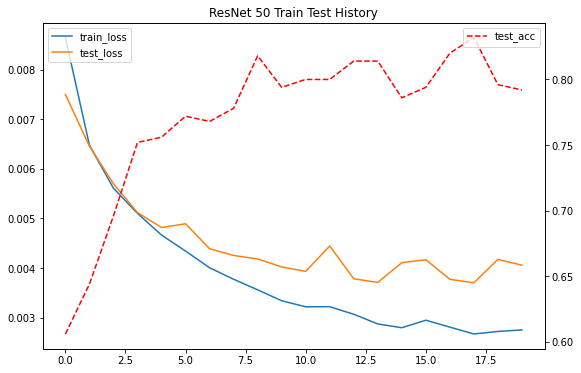

In [9]:
plot_train_val_stats(train_loss, test_loss, test_acc, title="ResNet 50 Train Test History")

### 11. Performance of ResNet 50-Layer on the Test Set (500 Images) using 80/20 (train/test) Split.

On this 80/20 train test split, the ResNet 50 achieve **macro f1-score of 0.82** and **accuracy of 0.83**. ResNet 50 performs the best on classifying viral pneumonia with precision of 0.92 and the worst on COVID with precision of 0.78. Again, we will further validate the architecture using a 5-fold cross validation.

                 precision    recall  f1-score   support

          COVID       0.78      0.82      0.80        85
   Lung_Opacity       0.80      0.80      0.80       142
         Normal       0.86      0.87      0.87       241
Viral Pneumonia       0.92      0.75      0.83        32

       accuracy                           0.83       500
      macro avg       0.84      0.81      0.82       500
   weighted avg       0.83      0.83      0.83       500



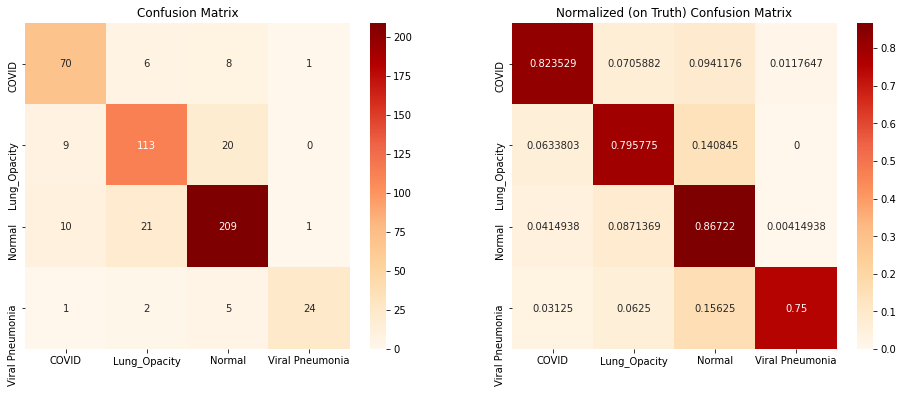

In [10]:
print(classification_report(test_results[0], test_results[1], target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(test_results[0], test_results[1]), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(test_results[0], test_results[1], normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix For ResNet 50")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

### 12. CNN Architecture 2: DenseNet 121-Layer
The second CNN architecture we proposed for this problem is DenseNet 121-Layer with about **7 millions of parameters**. According to the authors of this architecture, Huang et al. [1], DenseNet shows improvement on four benchmark datasets (CIFAR-10, CIFAR-100, SVHN, and ImageNet) over the previous state-of-art results, while **consuming less computational resources** (7 millions of parameters compared to the 20 millions of parameters in ResNet 50).

<figure class="image">
    <img src="https://miro.medium.com/max/875/1*B0urIaJjCIjFIz1MZOP5YQ.png" width="800" height="" />
    <figcaption>Fig 1. Architecture of the DenseNet 121-Layer [2]</figcaption>
</figure>

In this project, we will use the **feature extractor** of the DenseNet 121 pretrained on ImageNet dataset. Again, yhe images features learned in the ImageNet dataset can **well represent the features in other images**. Yet, we need to replace the output layer of densenet's classifier with a new convolutional layer that has correct number of outputs == 4, and **retrain the classifier** of on our dataset.

References:  
[1] Huang, G., et al., "Densely Connected Convolutional Networks", [https://arxiv.org/abs/1608.06993](https://arxiv.org/abs/1608.06993)  
[2] Ruiz, P., "Understanding and visualizing DenseNets", [https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a](https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a)

In [10]:
def make_pretrained_densenet121_and_optimizer(out_features=4, optimizer=optim.Adam, 
                                              learning_rate=1e-3, print_arch=False, 
                                              device=torch.device("cuda")):
    """
    :param out_features: number of output features
    :param optimizer: the type of optimizer used for this model
    :param learning_rate: the learning rate of the optimizer
    :param device: the device which the model will be trained on
    :return: model, optimizer
    """
    torch.cuda.empty_cache()
    model = densenet121(pretrained=True)

    # Freeze the training of feature extractor
    # We will just use the pretrained feature extractor
    # This will save a significant amount of time in trainig
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier of DenseNet 121 with a new classifier for our
    # radiography classification problems
    num_ftrs = model.classifier.in_features 
    model.classifier = nn.Linear(num_ftrs, out_features) 

    # Only optimize on the classifier, the rest is pretrained
    optimizer = optimizer(model.classifier.parameters(), lr=learning_rate)

    model = model.to(device) 

    print(f'Model has {sum(p.numel() for p in model.parameters())} parameters in total.')
    print(f'Among them, there are {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters need to be trained.\n')
    
    # Print the textual representation of model's architecture
    if print_arch:
        print(model)
        
    return model, optimizer

### 13. Train and Test the DenseNet 121 on pre-split Train & Test Datasets (2500 Images) for 20 epochs
Again, this is just a test run to see if the DenseNet 121 works on the Radiography Dataset. The train/test split of this pre-defined train & test datasets is **80%/20%**. We will further validate the performance of this model using a 5-Fold cross-validation in the subsequent cells. The performance of DenseNet 121 will also be compared with that of ResNet 50.

In [12]:
%%time

model, optimizer = make_pretrained_densenet121_and_optimizer(learning_rate=1e-3)

loss_func = nn.CrossEntropyLoss()

train_loss, _, test_loss, test_acc, _, test_results = train_val_model(model, train_loader, test_loader, optimizer, loss_func, 
                                                                      device, max_epoch=20, class_names=class_names,
                                                                      train_report=False, test_report=True,
                                                                      train_verbose=8)

Model has 6957956 parameters in total.
Among them, there are 4100 parameters need to be trained.

------------------------------EPOCH  1------------------------------
Train Epoch: 1 [0/2000 (0%)]	Loss: 0.010153   Accuracy: 34/128 (27)%
Train Epoch: 1 [1024/2000 (50%)]	Loss: 0.009339   Accuracy: 62/128 (48)%

Train set: Average loss: 0.0087 (6.419 sec)   Accuracy: 1118/2000 (56%)
Test set: Average loss: 0.0076,                Accuracy: 308/500 (62%)

                 precision    recall  f1-score   support

          COVID       1.00      0.02      0.05        85
   Lung_Opacity       0.71      0.50      0.59       142
         Normal       0.59      0.96      0.73       241
Viral Pneumonia       1.00      0.09      0.17        32

       accuracy                           0.62       500
      macro avg       0.82      0.39      0.38       500
   weighted avg       0.72      0.62      0.54       500

------------------------------EPOCH  2------------------------------
Train Epoch: 2 [0/

### 14. Train Test History of 20 Epochs for DenseNet 121-Layer
Notice that the train and test losses are still minimizing with very little oscillation. This may suggest us to use a larger learning rate and train the model with more epochs.

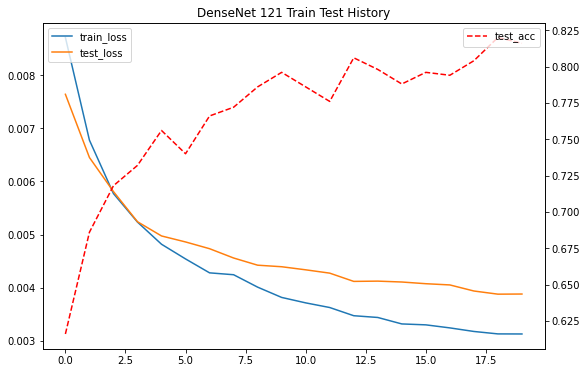

In [13]:
plot_train_val_stats(train_loss, test_loss, test_acc, title="DenseNet 121 Train Test History")

### 15. Performance of DenseNet 121-Layer on the same Test Set (500 Images) using 80/20 (train/test) Split.
On this 80/20 train test split, the DenseNet 121 achieve **macro f1-score of 0.81** and **accuracy of 0.82**. DenseNet 121 performs the best on classifying viral pneumonia with precision of 0.93 and the worst on Lung Opacity with precision of 0.76.

                 precision    recall  f1-score   support

          COVID       0.81      0.72      0.76        85
   Lung_Opacity       0.76      0.80      0.78       142
         Normal       0.85      0.88      0.86       241
Viral Pneumonia       0.93      0.78      0.85        32

       accuracy                           0.82       500
      macro avg       0.84      0.79      0.81       500
   weighted avg       0.82      0.82      0.82       500



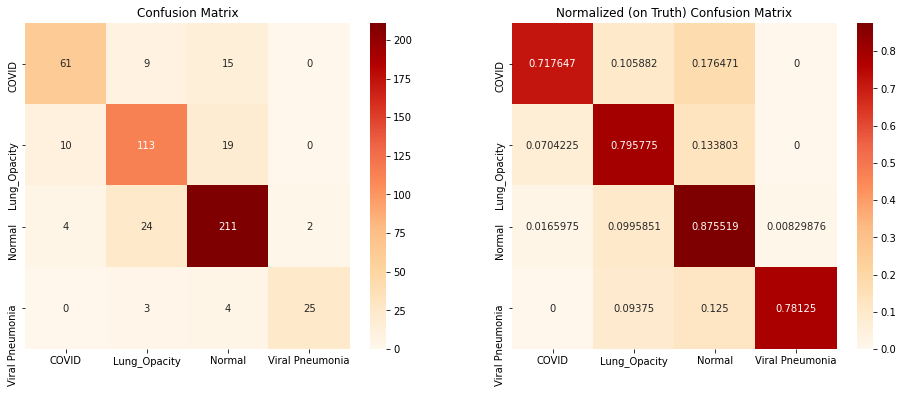

In [14]:
print(classification_report(test_results[0], test_results[1], target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(test_results[0], test_results[1]), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(test_results[0], test_results[1], normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

### 16. Function for Doing Stratified K-Fold Cross-Validation
The cell below contains the helper function for doing **Stratified/non-Stratified** K-Fold Cross-Validation. The functions will call `train_val_model()` internally.

`cross_val_predict`: Cross validate the model with K-Fold CV and get its prediction on each fold.

Notice that similar to how we sampled out the subset, we wish to **stratified on the class labels** when creating k-fold splits. Thus, each fold split will have **the same class ratios** as they were in the dataset. The stratification make sure that each fold will be a good representation of the whole dataset, and we do not bias specific classes in some folds.

The results of epoch with the **minimum test loss in each fold** will be saved and reported.

In [11]:
def cross_val_predict(make_model_func, dataset, testset=None, kfold=5, targets=None, learning_rate=1e-3,
                      optimizer=optim.Adam,
                      train_batch_size=128, test_batch_size=128,
                      stratified=False, random_state=0, torch_random_state=None,
                      report=True, fold_best_report=False, save_fold_models=False, 
                      heat_dissipate=False, return_raw_outputs=False, **kwargs):
    """
    Helper function for doing k-fold cross validation on a dataset using the given pytorch model
    
    :param make_model_func: The function that make a pytorch model and return an optimizer that optimizes the model
    :param dataset: pytorch Dataset for k-fold cv
    :param kfold: number of folds
    :param targets: target labels for the Dataset
    :param optimizer: type of the optimizer
    :param train_batch_size: size of the train batch
    :param test_batch_size: size of the test batch
    :param stratified: whether to use stratified k-fold or not
    :param random_state: random state of the Kfold spliter
    :param torch_random_state: random state for the torch module's functions
    :param report: whether to report the overall test performance on all folds or not
    :param fold_best_report: whether to report the model's best performance in each fold or not
    :param kwargs: keyword arguments for the train_val_model()
    
    :return: train loss of each fold, train accuracy of each fold, test loss of each fold, \ 
    test accuracy of each fold, test true labels, test predictions, test indices of all fold, \
    (and raw test outputs from each fold if return_raw_outputs)
    """
    folds_train_acc = []
    folds_train_loss = []
    folds_test_acc = []
    folds_test_loss = []
    folds_test_truths = []
    folds_test_preds = []
    folds_test_indices = []
    if return_raw_outputs:
        folds_raw_test_results = []
    
    # Whether use the stratified k-fold or not
    if stratified:
        kfold = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
    else:
        kfold = KFold(n_splits=kfold, shuffle=True, random_state=random_state)
    
    # Train and validate the model through each fold
    for fold_id, (train_indices, test_indices) in enumerate(kfold.split(dataset, targets)):
        print("*" * 31 + "Fold{:3d}".format(fold_id + 1) + "*" * 31 + "\n")
        
        trainData = torch.utils.data.Subset(dataset, train_indices.tolist())
        # If test set is given, then use the given test set
        if testset:
            testData = torch.utils.data.Subset(testset, test_indices.tolist())
        else:
            # Otherwise use the dataset
            testData = torch.utils.data.Subset(dataset, test_indices.tolist())
        
        # Set up the torch random seed: for reproducibility
        if torch_random_state:
            torch.manual_seed(random_state)

        # pin the memory and use workers for subprocessing routine
        # This will greatly speed up the data loading
        # See Documentation: https://pytorch.org/docs/stable/data.html#memory-pinning
        loader_kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda" else {}

        train_loader = torch.utils.data.DataLoader(trainData,
                                                   batch_size=train_batch_size, shuffle=True, **loader_kwargs)
        test_loader = torch.utils.data.DataLoader(testData,
                                                  batch_size=test_batch_size, shuffle=False, **loader_kwargs)
        
        # Make the model and get the associated optimizer
        model, ret_optimizer = make_model_func(optimizer=optimizer, learning_rate=learning_rate)
        
        # Call train and validation on the model
        train_loss, train_acc, test_loss, test_acc, train_res, test_res = train_val_model(model, train_loader, test_loader, 
                                                                                          ret_optimizer,
                                                                                          save_model=save_fold_models, 
                                                                                          saved_model_path="best_model_fold{:02d}.pth"
                                                                                          .format(fold_id + 1), 
                                                                                          return_raw_outputs=return_raw_outputs,
                                                                                          **kwargs)
        
        # If report the best performance in each fold
        if fold_best_report:
            print(classification_report(test_res[0], test_res[1], target_names=class_names, zero_division=0))
        
        folds_train_loss.append(train_loss)
        folds_train_acc.append(train_acc)
        
        folds_test_acc.append(test_acc)
        folds_test_loss.append(test_loss)
        
        folds_test_truths += test_res[0]
        folds_test_preds += test_res[1]
        folds_test_indices.append(test_indices.tolist())
        if return_raw_outputs:
            folds_raw_test_results += test_res[2]
        
        # Just in case if the cross validation takes a long time 
        # (~2 hours for whole dataset 5-fold cv on RTX2080 Ti)
        # You may wish to suspend the execution for a small while
        # time.sleep() is not CPU intensive
        if heat_dissipate:
            print("Heat Dissipation: for 60 seconds")
            time.sleep(60)
    # If report the overall performance on all folds (whole dataset)
    if report:
        print("*" * 31 + "Dataset" + "*" * 31)
        print(classification_report(folds_test_truths, folds_test_preds, target_names=class_names, zero_division=0))
        
    if return_raw_outputs:
        return folds_train_loss, folds_train_acc, folds_test_loss, folds_test_acc, \
    folds_test_truths, folds_test_preds, folds_test_indices, folds_raw_test_results
    else:
        return folds_train_loss, folds_train_acc, folds_test_loss, folds_test_acc, \
    folds_test_truths, folds_test_preds, folds_test_indices 

### 17. Example of Stratified 5-Fold
Below, I will show you that we can preserver the exact ratios of classes in each fold using the stratified 5-fold.

In [11]:
# Number of folds
num_fold = 5
# Fixed random state for reproducibility
random_state = 0

kfold = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=random_state)
fold_indices = []

for (train_indices, test_indices) in kfold.split(data_xrays, data_xrays.targets):
    fold_indices.append(test_indices)

print("nth Fold {:>17s} {:>17s} {:>17s} {:>17s}".format(data_xrays.classes[0],
                                                        data_xrays.classes[1],
                                                        data_xrays.classes[2],
                                                        data_xrays.classes[3]))
for fold_id in range(len(fold_indices)):
    indices = fold_indices[fold_id]
    target_labels =  np.array([data_xrays.targets[index] for index in indices])
    classes, class_counts = np.unique(target_labels, return_counts=True)
    print("Fold {:2d}: {:11d} ({:2.0f})% {:11d} ({:2.0f})% {:11d} ({:2.0f})% {:12d} ({:1.0f})%"
          .format(fold_id + 1,
                  class_counts[0], class_counts[0] / len(indices) * 100,
                  class_counts[1], class_counts[1] / len(indices) * 100,
                  class_counts[2], class_counts[2] / len(indices) * 100,
                  class_counts[3], class_counts[3] / len(indices) * 100))
classes, class_counts = np.unique(data_xrays.targets, return_counts=True)

print("Total:   {:11d} ({:2.0f})% {:11d} ({:2.0f})% {:11d} ({:2.0f})% {:12d} ({:1.0f})%"
      .format(class_counts[0], class_counts[0] / len(data_xrays.targets) * 100,
              class_counts[1], class_counts[1] / len(data_xrays.targets) * 100,
              class_counts[2], class_counts[2] / len(data_xrays.targets) * 100,
              class_counts[3], class_counts[3] / len(data_xrays.targets) * 100))

nth Fold             COVID      Lung_Opacity            Normal   Viral Pneumonia
Fold  1:         724 (17)%        1202 (28)%        2038 (48)%          269 (6)%
Fold  2:         723 (17)%        1203 (28)%        2038 (48)%          269 (6)%
Fold  3:         723 (17)%        1203 (28)%        2038 (48)%          269 (6)%
Fold  4:         723 (17)%        1202 (28)%        2039 (48)%          269 (6)%
Fold  5:         723 (17)%        1202 (28)%        2039 (48)%          269 (6)%
Total:          3616 (17)%        6012 (28)%       10192 (48)%         1345 (6)%


### 18. 5-Fold Cross Validation on the Subset (2500 Images)
Now, we will evaluate the two propsoed architectures' performances on the **Subset** (2500 images) using **5-fold cross validation**. 

To **control the variables** in this experiment, we fixed the **`random_state`** of stratified k-fold spliter to **0** for both the ResNet 50 and DenseNet 121's 5-fold CV. Therefore, two models will be trained and validated **on the same set of fold splits**.

In [12]:
# Load the saved statistics of 5-fold cvs on ResNet 50 and Dense 121 
fold_indices_resnet = pd.read_csv("subset_saved_5_fold_resnet50_results.csv")["Sample_Index"]
fold_indices_densenet = pd.read_csv("subset_saved_5_fold_densenet121_results.csv")["Sample_Index"]

# Check if every pair of indices are matched
print("Same set of 5-fold splits?:")
np.all(fold_indices_resnet == fold_indices_densenet)

Same set of 5-fold splits?:


True

### 19. 5-Fold Cross Validation on the Subset: ResNet 50-Layer
`model`: ResNet 50  
`optimizer`: `nn.CrossEntropyLoss()`  
`kfold` : 5  
`stratified`: `True`  
`max_epoch`: 25  

Notes: Thie cell may takes **17 minutes** to be finished. If you are interested in the results, you may wish to read through the outputs from each cell instead.

In [13]:
%%time

cross_results_resnet = cross_val_predict(make_pretrained_resnet_50_and_optimizer, ConcatDataset([trainData, testData]),
                                         kfold=5, loss_func=nn.CrossEntropyLoss(),
                                         targets=np.array(data_xrays.targets)[trainData.indices + testData.indices],
                                         stratified=True,
                                         device=device, max_epoch=25, 
                                         class_names=class_names, test_report=False, train_verbose=None, 
                                         random_state=0,
                                         torch_random_state=0, 
                                         fold_best_report=True)

*******************************Fold  1*******************************

Model has 23639428 parameters in total.
Among them, there are 131396 parameters need to be trained.

------------------------------EPOCH  1------------------------------

Train set: Average loss: 0.0089 (7.285 sec)   Accuracy: 1056/2000 (53%)
Test set: Average loss: 0.0080,                Accuracy: 265/500 (53%)

------------------------------EPOCH  2------------------------------

Train set: Average loss: 0.0069 (6.328 sec)   Accuracy: 1299/2000 (65%)
Test set: Average loss: 0.0065,                Accuracy: 355/500 (71%)

------------------------------EPOCH  3------------------------------

Train set: Average loss: 0.0057 (6.325 sec)   Accuracy: 1481/2000 (74%)
Test set: Average loss: 0.0058,                Accuracy: 341/500 (68%)

------------------------------EPOCH  4------------------------------

Train set: Average loss: 0.0050 (6.276 sec)   Accuracy: 1531/2000 (77%)
Test set: Average loss: 0.0047,             

### 20. Statistics of 5-Fold Cross Validation with ResNet 50-Layer
Now, let's visualize the ResNet 50's performance on the 2500 images using the 5-fold cross validation. The cell below will output the `classification_report` and plot the `confusion_matrix`.

The results are the **test results of epochs with the minimum loss** at each fold.

                 precision    recall  f1-score   support

          COVID       0.82      0.79      0.80       427
   Lung_Opacity       0.82      0.79      0.80       710
         Normal       0.85      0.88      0.86      1204
Viral Pneumonia       0.89      0.86      0.88       159

       accuracy                           0.84      2500
      macro avg       0.84      0.83      0.84      2500
   weighted avg       0.84      0.84      0.84      2500



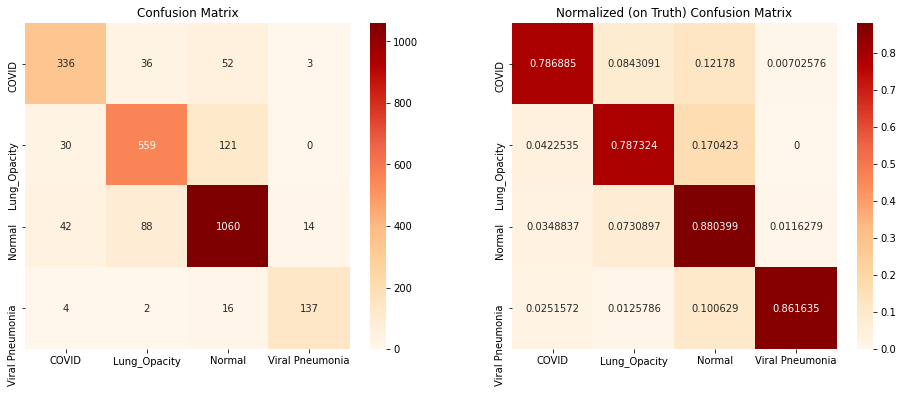

In [14]:
ctruth = cross_results_resnet[-3]
pred = cross_results_resnet[-2]

print(classification_report(truth, pred, 
                            target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(truth, pred), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(truth, pred, normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

According the classification report, ResNet 50 achieves **macro f1** score of **0.84** and **accuracy of 0.84** on the **2500** images. Based on the precision score, ResNet **performs the best on the Viral Pneumonia** classification with support of 159 samples. ResNet performs **relatively poor on the COVID** (support of 427 images) and **Lung_Opacity** (support of 710 images) with **precision of 0.82**. 

Notice in the **normalized confusion matrix**, **17.04%** of the Lung_Opacity patients are misclassified as the normal patients. 

There are two possible reasons for this error: 

* (1) **similar spatial features** between normal and lung opacity patients. In contrast to the viral pneumonia where the Lung area are globally hazy, the lung opacity is sometimes a **local blockage** of airways that increase **opacity of only certain local regions**. Thus, the lung opacity CXR images in general may still look like a normal patient's CXR. 
* (2) **Class imbalanced**: Too many normal patients' CXR (1204 images) in the dataset make model bias toward the optimization on normal class.

---

### 21. 5-Fold Cross Validation on the Subset: DenseNet 121-Layer
`model`: DenseNet 121
`optimizer`: `nn.CrossEntropyLoss()`  
`kfold` : 5  
`stratified`: `True`  
`max_epoch`: 25  

Notes: Thie cell may takes **17 minutes** to be finished. If you are interested in the results, you may wish to read through the outputs from each cell instead.

In [15]:
%%time

cross_results_densenet = cross_val_predict(make_pretrained_densenet121_and_optimizer, ConcatDataset([trainData, testData]),
                                           kfold=5, loss_func=nn.CrossEntropyLoss(),
                                           targets=np.array(data_xrays.targets)[trainData.indices + testData.indices],
                                           stratified=True,
                                           device=device, max_epoch=25, 
                                           class_names=class_names, test_report=False, train_verbose=None, 
                                           random_state=0,
                                           torch_random_state=0, 
                                           fold_best_report=True)

*******************************Fold  1*******************************

Model has 6957956 parameters in total.
Among them, there are 4100 parameters need to be trained.

------------------------------EPOCH  1------------------------------

Train set: Average loss: 0.0091 (6.349 sec)   Accuracy: 1011/2000 (51%)
Test set: Average loss: 0.0081,                Accuracy: 310/500 (62%)

------------------------------EPOCH  2------------------------------

Train set: Average loss: 0.0069 (6.380 sec)   Accuracy: 1352/2000 (68%)
Test set: Average loss: 0.0067,                Accuracy: 332/500 (66%)

------------------------------EPOCH  3------------------------------

Train set: Average loss: 0.0059 (6.433 sec)   Accuracy: 1456/2000 (73%)
Test set: Average loss: 0.0057,                Accuracy: 373/500 (75%)

------------------------------EPOCH  4------------------------------

Train set: Average loss: 0.0053 (6.448 sec)   Accuracy: 1525/2000 (76%)
Test set: Average loss: 0.0052,                

### 22. Statistics of 5-Fold Cross Validation with DenseNet 121-Layer
Now, let's visualize the DenseNet 121's performance on the 2500 images using the 5-fold cross validation. The cell below will output the `classification_report` and plot the `confusion_matrix`.

The results are the **test results of epochs with the minimum loss** at each fold.

                 precision    recall  f1-score   support

          COVID       0.85      0.72      0.78       427
   Lung_Opacity       0.79      0.81      0.80       710
         Normal       0.85      0.89      0.87      1204
Viral Pneumonia       0.92      0.83      0.87       159

       accuracy                           0.84      2500
      macro avg       0.85      0.81      0.83      2500
   weighted avg       0.84      0.84      0.84      2500



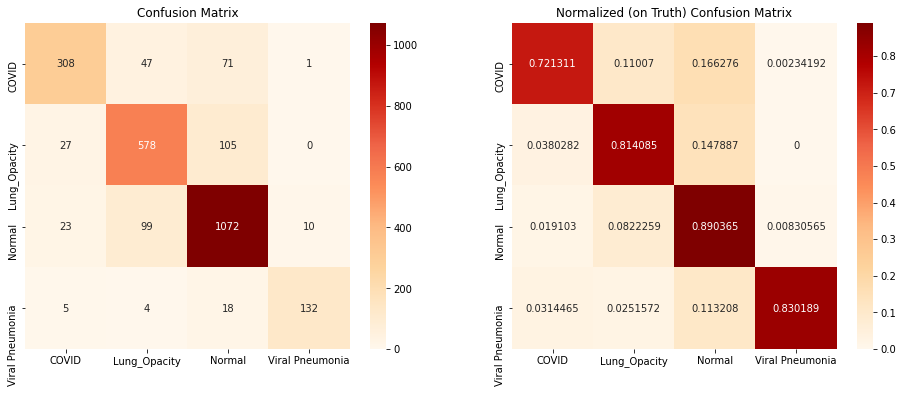

In [22]:
truth = cross_results_densenet[-3]
pred = cross_results_densenet[-2]

print(classification_report(truth, pred, 
                            target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(truth, pred), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(truth, pred, normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

According the classification report, DenseNet 121 achieves **macro f1** score of **0.84** and **accuracy of 0.83** on the **2500** images. Based on the precision score, DenseNet 121 **performs the best on the Viral Pneumonia** classification with score of **0.92** and support of 159 samples. ResNet performs **relatively poor on the Lung_Opacity** (support of 710 images) with **precision of 0.79**. 

Notice in the **normalized confusion matrix**, **16.62%** of the COVID patients and **14.78%** of the lung opacity patients are misclassified as the normal patients. 

Again, there are two possible reasons for this error: 

* (1) **similar spatial features** among the CXR images of the COVID, Lung opacity, and normal patients. 
* (2) **Class imbalanced**: Too many normal patients' CXR (1204 images) in the dataset make model bias toward the **optimization on normal class**.

---

Based on the **macro f1 score** and **overall accuracy**, the performance of ResNet-50 and DenseNet-121 are **very similar** on the 5-Fold CV using the subset. Both the **ResNet-50** and **DenseNet-121** achieve the macro f1 score of **0.84**. However, as we saw in the **section/cell 10 and 14**, the models are not quite converge with training of 20 epochs. It may be helpful to train the models with more epochs (e.g. 30 epochs) or tuning the hyper-parameters such as **Learning rate** and **train batch size**. 

To further differentiate the performance between **ResNet-50** and **DenseNet-121**, we will apply a **Grid Search** on sets of hyperparameters that includes the CNN architecture (ResNet 50 or DenseNet 121), learning rate of Adam Optimizer, and train batch size. 

### 23. Function for Doing GridSearch with K-Fold Cross-Validation
The cell below contains a function for doing hyperparameters optimization using Grid Search with K-Fold CV. The function will call `cross_val_predict` internally.

`pytorch_gridsearch_cv`: Validating the models with K-fold CV using the sets of hyperparameters given by the input. The function will return a dataframe of grid search results. Results are sorted by the model's performance measured by the given metrics.

In [14]:
def pytorch_gridsearch_cv(dataset, targets, make_model_func=None, params=[], 
                          metric=metrics.f1_score, metrics_params={"average":"macro"}, 
                          cv_params={"kfold":5, "stratified":True}, report_param=True, **kwargs):
    """
    Helper function for doing grid search cv on the pytorch's model
    
    :param dataset: pytorch Dataset
    :param targets: a list of targets label for the data in the dataset
    :param make_model_func: a function that makes and returns a model and optimizer \
    if None, the make_model_func must be one of the params
    :param params: sets of hyper-parameters used to tune the models
    :param metric: the metric function that measures the model's performance
    :param metrics_params: function parameters for the given metric function
    :param cv_params: the parameters for the cross validation
    :param report_param: whether report/print the set of parameters used for each search in the output
    :param kwargs: keyword arguments for the cross_val_predict
    :return: pd.Dataframe of the grid search results
    """
    param_list = []
    metric_scores_list = []
    cv_train_loss_list = []
    cv_train_acc_list = []
    cv_test_loss_list = []
    cv_test_acc_list = []
    folds_test_acc_list = []
    
    # Get a list of combinations of hyper-parameters
    list_param_sets = list(ParameterGrid(params))
    nth_search = 1
    
    # Search over the sets of hyper-parameters
    for param_set in list_param_sets:
        print("^" * 30 + "Search{:3d}".format(nth_search) + "^" * 30)
        
        # If report the set of parameters used for each search
        if report_param:
            print("Selected Parameters:")
            print(param_set)
        param_set.update(cv_params)
        param_set.update(kwargs)
        
        # If the make model function is given
        if make_model_func != None:
            param_set["make_model_func"] = make_model_func
            
        # Doing the cross validation on the model with a set of hyper-parameters
        cross_results = cross_val_predict(dataset=dataset,
                                          targets=targets,
                                          **param_set)
        
        # Retrieve the cross validation results
        ret_truths = cross_results[4]
        ret_preds = cross_results[5]
        metric_score = metric(ret_truths, ret_preds, **metrics_params)
        test_acc = metrics.accuracy_score(ret_truths, ret_preds, normalize=True)
        
        metric_scores_list.append(metric_score)
        param_set["make_model_func"] = str(param_set["make_model_func"])
        param_list.append(param_set)
        cv_train_loss_list.append(np.array(cross_results[0]).mean())
        cv_train_acc_list.append(np.array(cross_results[1]).mean())
        cv_test_loss_list.append(np.array(cross_results[2]).mean())
        cv_test_acc_list.append(np.array(cross_results[3]).mean())
        folds_test_acc_list.append(test_acc)
        
        # Print the tuned model's performance score measured by the given metrics
        print("Metric Scores: {:.3f}\n".format(metric_score))
        nth_search += 1
            
    # Return the dataframe of grid search results
    return pd.DataFrame(data={"metric_scores": metric_scores_list, "selected_parameters": param_list,
                              "average_cv_train_loss": cv_train_loss_list, "average_cv_train_acc": cv_train_acc_list,
                              "average_cv_test_loss": cv_test_loss_list, "average_cv_test_acc": cv_test_acc_list,
                              "overall_cv_test_acc": folds_test_acc_list}).sort_values(by="metric_scores", ascending=False)

### 24. GridSearch Cross-Validation (5-Fold) on the Subset (2500 Images)
Now, let do a Grid Search with stratified 5-Fold cross validation on the subset.

The set of hyperparameters are:
`CNN Architecture`: [ResNet 50-Layer, DenseNet 121-Layer]  
`Learning Rate of Adam Optimizer`: [0.001, 0.0001]  
`Train Batch Size`: [128, 256]

We will train each fold with **30 epochs** and use the **results of epochs with minimum test loss**. The **performance** of model in each search will be measured using the **macro f1 score**. 

Warning: this cell may take **~3 hours** to be finished.

In [11]:
%%time


grid_cv_params = {'make_model_func': [make_pretrained_resnet_50_and_optimizer,
                                      make_pretrained_densenet121_and_optimizer],
                  'learning_rate': [1e-3, 1e-4],
                  'train_batch_size': [128, 256]}

gridcv_df = pytorch_gridsearch_cv(ConcatDataset([trainData, testData]), 
                                  targets=np.array(data_xrays.targets)[trainData.indices + testData.indices], 
                                  params=grid_cv_params,
                                  cv_params={"kfold":5, "stratified":True},
                                  metric=metrics.f1_score,
                                  metrics_params={"average":"macro"},
                                  max_epoch=30, loss_func=nn.CrossEntropyLoss(),
                                  device=device, 
                                  class_names=class_names, test_report=False, train_verbose=None, 
                                  torch_random_state=0, 
                                  fold_best_report=False)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Search  1^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Selected Parameters:
{'learning_rate': 0.001, 'make_model_func': <function make_pretrained_resnet_50_and_optimizer at 0x7fe61993a2f0>, 'train_batch_size': 128}
*******************************Fold  1*******************************

Model has 23639428 parameters in total.
Among them, there are 131396 parameters need to be trained.

------------------------------EPOCH  1------------------------------

Train set: Average loss: 0.0089 (6.708 sec)   Accuracy: 1056/2000 (53%)
Test set: Average loss: 0.0040,                Accuracy: 265/500 (53%)

------------------------------EPOCH  2------------------------------

Train set: Average loss: 0.0069 (6.372 sec)   Accuracy: 1299/2000 (65%)
Test set: Average loss: 0.0032,                Accuracy: 355/500 (71%)

------------------------------EPOCH  3------------------------------

Train set: Average loss: 0.0057 (6.384 sec)   Accuracy: 1481/2000 (74%)
Test set: Average loss: 0.00

### 25. 5-Fold CV Grid Search Results

Now, let's check the results of 5-Fold CV Grid Search. If you did not run the `pytorch_gridsearch_cv`, you could use the **saved results** in `saved_5fold_gridsearch_with_8_searches.csv`. If you ran the `pytorch_gridsearch_cv` please comment out the line that reads in the saved results.

In [11]:
# Comment the line below out if you run the pytorch_gridsearch_cv.
# Otherwise, load the saved grid search results
gridcv_df = pd.read_csv("saved_5fold_gridsearch_with_8_searches.csv")

def parse_param_dict(row):
    """
    :param
    """
    params_row = row[:row.find(", 'kfold'")] + "}"
    parsed_dict = ast.literal_eval(params_row)
    model_str = parsed_dict["make_model_func"]
    parsed_dict["make_model_func"] = model_str[model_str.find("pretrained"): model_str.find("_and")]
    return parsed_dict
    
gridcv_df["selected_parameters"] = gridcv_df["selected_parameters"].apply(parse_param_dict)
gridcv_df = pd.concat([gridcv_df, gridcv_df["selected_parameters"].apply(pd.Series)], axis=1)


display(gridcv_df.loc[:, ["nth_search", "metric_scores", "overall_cv_test_acc", 
                          "learning_rate", "make_model_func", "train_batch_size"]])

,nth_search,metric_scores,overall_cv_test_acc,learning_rate,make_model_func,train_batch_size
0,2,0.838830,0.8400,0.0010,pretrained_densenet121,128
1,0,0.834912,0.8352,0.0010,pretrained_resnet_50,128
2,1,0.833260,0.8344,0.0010,pretrained_resnet_50,256
3,3,0.821924,0.8316,0.0010,pretrained_densenet121,256
4,4,0.781782,0.8012,0.0001,pretrained_resnet_50,128
5,5,0.710830,0.7644,0.0001,pretrained_resnet_50,256
6,6,0.636754,0.7444,0.0001,pretrained_densenet121,128
7,7,0.498536,0.7044,0.0001,pretrained_densenet121,256


As suggested by the grid search results, the deep learning models perform better on the dataset when **learning rate** is larger, **0.001**, while the **train batch size** is smaller, **128**. In other words, the models performs better when we optimize the model's weights with a larger step and adjust the weights more frequently. 

Based on the macro f1 score, the **pretrained DenseNet 121 performs the best** with learning rate of 0.001 and train batch size 128. The difference in performance between the pretrained DenseNet 121 and pretrained ResNet 50 are, however, **relatively minimal** (the difference between the macro f1 scores of **top-1 search** and **top-2 search** is 0.8388 - 0.8349 = **~0.004**).

Yet, there are three additional reasons for me to **use the DenseNet 121** instead of ResNet 50:

* (1) Remember that the DenseNet 121 has only **~7 millions of parameters** while ResNet 50 has about **20 millions of parameters**. The deep learning model with **more parameters**, though, can learn more complex patterns in the data, but they have **much higher risks of overfitting** as they capture and bias the very detailed information.
* (2) DenseNet with fewer parameters also requires less computational resources.
* (3)Moreover, the **7 millions of parameters** is almost unmanageable when we try to interpret the model. Models, such as ResNet, with tens of millions of parameters are mostly inexplicable.

---

### 26. 5-Fold Cross Validation of DenseNet-121 On the Whole Dataset (21165 Images)
In the cell below, we will train the **DenseNet-121** pretrained on ImageNet using **5-Fold cross validation** on the whole Dataset (21165 images). We will use the `Cross Entropy` loss function and `Adam optimizer` with **learning rate of 0.001**. The train batch size is **128** (images), and the model will be trained for **20 epochs** in each fold.


**Warning: This cell can take ~2 hours to be finished.** If you are interesting in the results, you may wish to read through the cell outputs and load the **saved results** from the pickle file, [saved_5_fold_densenet121_results.pkl](saved_5_fold_densenet121_results.pkl).

In [11]:
%%time

cross_results = cross_val_predict(make_pretrained_densenet121_and_optimizer, 
                                  data_xrays,
                                  targets=np.array(data_xrays.targets),
                                  kfold=5,
                                  learning_rate=1e-3,
                                  train_batch_size=128,
                                  loss_func=nn.CrossEntropyLoss(),
                                  stratified=True,
                                  device=device, 
                                  max_epoch=20, 
                                  class_names=class_names, test_report=False, train_verbose=None, 
                                  torch_random_state=0, 
                                  heat_dissipate=True,
                                  fold_best_report=True,
                                  save_fold_models=True,
                                  return_raw_outputs=True)

*******************************Fold  1*******************************

Model has 6957956 parameters in total.
Among them, there are 4100 parameters need to be trained.

------------------------------EPOCH  1------------------------------

Train set: Average loss: 0.0056 (77.537 sec)   Accuracy: 12343/16932 (73%)
Test set: Average loss: 0.0044,                Accuracy: 3377/4233 (80%)

------------------------------EPOCH  2------------------------------

Train set: Average loss: 0.0039 (57.826 sec)   Accuracy: 13952/16932 (82%)
Test set: Average loss: 0.0037,                Accuracy: 3562/4233 (84%)

------------------------------EPOCH  3------------------------------

Train set: Average loss: 0.0035 (56.719 sec)   Accuracy: 14295/16932 (84%)
Test set: Average loss: 0.0034,                Accuracy: 3579/4233 (85%)

------------------------------EPOCH  4------------------------------

Train set: Average loss: 0.0033 (55.560 sec)   Accuracy: 14379/16932 (85%)
Test set: Average loss: 0.003

### 27. Statistics of the DenseNet 121's 5-Fold Cross Validation on the Whole Dataset

In [3]:
# Load the saved 5-fold cross validation results
with open("with_raw_outputs_saved_5_fold_densenet121_results.pkl", "rb") as infile:
    cross_results = pickle.load(infile)
infile.close()

                 precision    recall  f1-score   support

          COVID       0.85      0.83      0.84      3616
   Lung_Opacity       0.85      0.83      0.84      6012
         Normal       0.88      0.91      0.89     10192
Viral Pneumonia       0.94      0.91      0.93      1345

       accuracy                           0.87     21165
      macro avg       0.88      0.87      0.88     21165
   weighted avg       0.87      0.87      0.87     21165



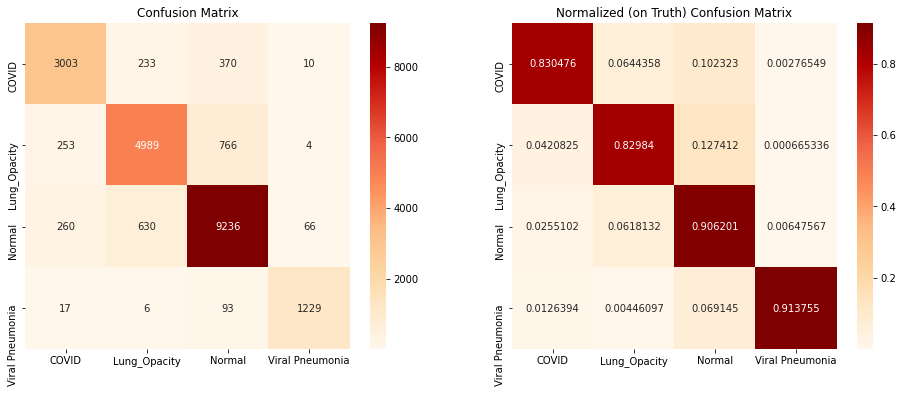

In [14]:
print(classification_report(cross_results[-4], cross_results[-3], target_names=class_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(cross_results[-4], cross_results[-3]), 
                       columns=class_names, 
                       index=class_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(cross_results[-4], cross_results[-3], normalize="true"), 
                            columns=class_names, 
                            index=class_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

According to the 5-Fold cross validation results, **DenseNet 121** achieve the **macro f1 score** of `0.88` on four classes and overall **accuracy** of `0.87`. DenseNet-121 performs the **best on classifying the viral pneumonia**, which the model achieve a **precision of 0.94**. The model performs **relatively poor** on classifying the **COVID and Lung opacity** with precisions of **0.85**.

Notice that there are **~10%** of COVID patients , **~13%** of lung opacity patients, and **~7%** of the Viral pneumonia patients being misclassified as the normal patients. The macro recall on all four classes is **0.87**.

---

### 28. How do these Results do when Compared to the Human Experts?

According to the Islam et al.[1], clinicians have an **accuracy of 80.6%** when diagnosing COVID-19 using patients' Chest X-ray Images. **DenseNet** achieves **higher accuracy of 83%** ($= \frac{3003}{3616} \times 100\%$). Clinicians also incorrectly conclude COVID-19 infection in **28.5%** of normal patients [1]. There are only **260 (2.5% of)** normal patients being classified as COVID by DenseNet-121. Smaller portion of patients are misclassified as COVID-19 infected.

However, we are more interested in the **false negative rate** when assessing the diagose accuracy of fatal diseases, such as COVID-19. According to the Cellina et al. [2], human experts' diagnosis of COVID-19 using Chest X-rays has a **sensitivity of 69%**. The sensitivity/recall of DenseNet's classificatio on COVID-19 is **0.83 (83%)**, which is much higher than the human experts.

The benefits of using Chest X-rays in diagnosing the COVID-19 infections includes **giving timely test results** (laboratory tests usually need more than 24 hours) and **high accuracy of diagnosis**. 


References:  
[1] Islam, N., et al., "How accurate is chest imaging for diagnosing COVID-19?", [https://www.cochrane.org/CD013639/INFECTN_how-accurate-chest-imaging-diagnosing-covid-19](https://www.cochrane.org/CD013639/INFECTN_how-accurate-chest-imaging-diagnosing-covid-19)  
[2] Cellina, M., et al., "False negative chest X-Rays in patients affected by COVID-19 pneumonia and corresponding chest CT findings",[https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7211752/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7211752/)

### 29. ROC Curve for the Classification of each Class.
The cell below will print the ROC curves for the classification of each class and a macro ROC curve.

The codes in the cell below come from the **scikit-learn's** tutorial for plotting ROC curve for multiclass classification problems. [https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem)

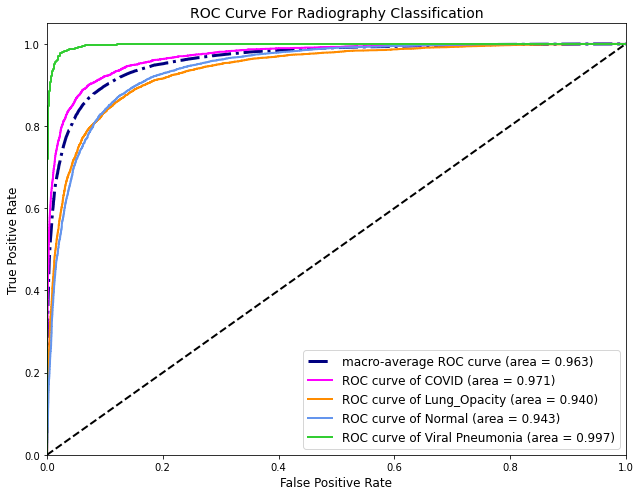

In [15]:
lw = 2

y_test = np.array(cross_results[-4]).reshape(-1, 1)

ohe_encoder = OneHotEncoder()
y_test = ohe_encoder.fit_transform(y_test).toarray()
n_classes = y_test.shape[1]

y_score = np.array(cross_results[-1])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle='-.', linewidth=3)

colors = ['magenta', 'darkorange', 'cornflowerblue', 'limegreen']
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle='-',
             label='ROC curve of {0:s} (area = {1:0.3f})'
             ''.format(data_xrays.classes[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve For Radiography Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

Notice that we achieve a **marco (unweighted) AUC of 0.963**. As suggested by the AUC, we have the best performance on classifying the **Viral pneumonia infection** with a AUC of **0.997**.

---

### 30. Grouping All Dieased Patients into the Dieased Class: Overall FNR in Diagnosing
We will group patients with COVID, Lung Opacity, and Viral Pneumonia into a single label of diseased. This will allow us to see how many diseased patients will being **misclassified as healthy** (who would not get treatments or further investigations).

              precision    recall  f1-score   support

      Normal       0.88      0.91      0.89     10192
    Diseased       0.91      0.89      0.90     10973

    accuracy                           0.90     21165
   macro avg       0.90      0.90      0.90     21165
weighted avg       0.90      0.90      0.90     21165



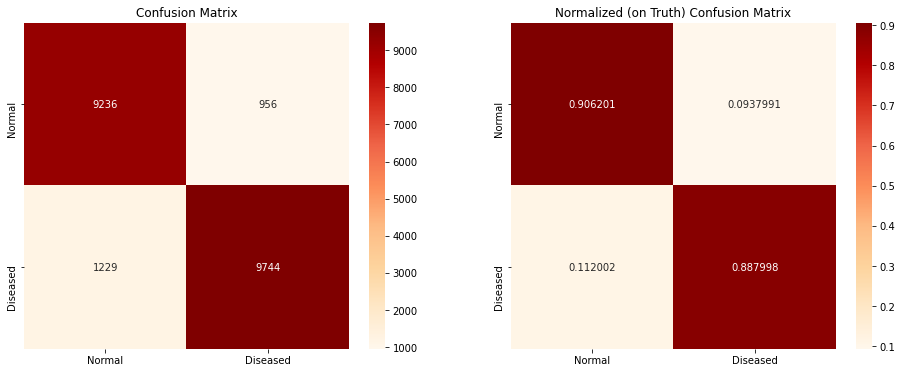

In [10]:
disease_truth = [0 if truth == data_xrays.class_to_idx["Normal"] else 1 for truth in cross_results[-4]]
disease_pred = [0 if pred == data_xrays.class_to_idx["Normal"] else 1 for pred in cross_results[-3]]

diseased_target_names = ["Normal", "Diseased"]

print(classification_report(disease_truth, disease_pred, target_names=diseased_target_names, zero_division=0))

df_conf = pd.DataFrame(data=metrics.confusion_matrix(disease_truth, disease_pred), 
                       columns=diseased_target_names, 
                       index=diseased_target_names)

df_conf_norm = pd.DataFrame(data=metrics.confusion_matrix(disease_truth, disease_pred, normalize="true"), 
                            columns=diseased_target_names, 
                            index=diseased_target_names)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("Confusion Matrix")
sns.heatmap(df_conf, cmap="OrRd", ax=ax[0], annot=True, fmt='g')
ax[1].set_title("Normalized (on Truth) Confusion Matrix")
sns.heatmap(df_conf_norm, cmap="OrRd", ax=ax[1], annot=True, fmt='g')
plt.show()

About **11.1%** of the diseased patients will be misclassified as healthy by the DenseNet-121. This FNR is better than that of the human clinicians when using Chest X-ray images. 

However, the results still expose a problem of using the trained DenseNet-121 alone in diagnosing COVID infection. The results from the deep learning models should be **used as an aid/a reference** for clinicians, but they should **not replace** the clinican's assessments.

---

### 31. Visualize the Filters and Extracted Features
Though convolutional neural network, as a black box model, is usually criticized for being **inexplicable**, we can still easily **visualize** the model's **trained filters** and their **features output**.

The method which I used to visualize the filters and feature maps is inspired from **Jason Brownlee**'s post, ["How to Visualize Filters and Feature Maps in Convolutional Neural Networks"](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/). Notice that Brownlee used the **Keras Model** in his tutorial. If you are using the pytorch, you may wish to use the codes in the subsequent cells of this notebook.  

Let's visualize some of the trained filters of the DenseNet-121  
Set print_arch to `True` if you wish to see the textual representation of the DenseNet-121's architecture.

In [12]:
model, optimizer = make_pretrained_densenet121_and_optimizer(print_arch=False)
model.load_state_dict(torch.load("saved_models/best_model_fold01.pth"))

Model has 6957956 parameters in total.
Among them, there are 4100 parameters need to be trained.



<All keys matched successfully>

### 32. Visualize Filters and Features of the First Dense Layer of the First Dense Block
Remember that a learnable filter in the convolutional layer is just **a stack of different spatial filters**.

We can visualize the filter and the output feature map from the filter in the same way as we did in the [section 19 of DataPrep_EDA.ipynb](DataPrep_EDA.ipynb).

In [13]:
model.eval()
np.random.seed(0)
index = np.random.choice(len(data_xrays))
image = torch.unsqueeze(data_xrays[index][0], dim=0)
# use torch.device("cpu") if you don't want to use GPU
x = model.features.conv0(image.to(torch.device("cuda")))
x = model.features.norm0(x)
x = model.features.relu0(x)
x = model.features.pool0(x)
x = model.features.denseblock1.denselayer1.conv1(x)
print("Feature Maps:   " + str(x.shape))

# Get the weights/parameters of the last output layer
features_dense_blk_1 = model.features.denseblock1.denselayer1.conv2.weight.cpu().numpy()
print("Filter's shape: " + str(features_dense_blk_1.shape))

Feature Maps:   torch.Size([1, 128, 64, 64])
Filter's shape: (32, 128, 3, 3)


---

Notice that the feature maps plotted below are **not the direct result** of convolutions between the **input image** and **learnable filters below**. There are **several layers** of convolutions and regularization (e.g. dropout) **happened before** the first convolutional layer of Dense Block 1.

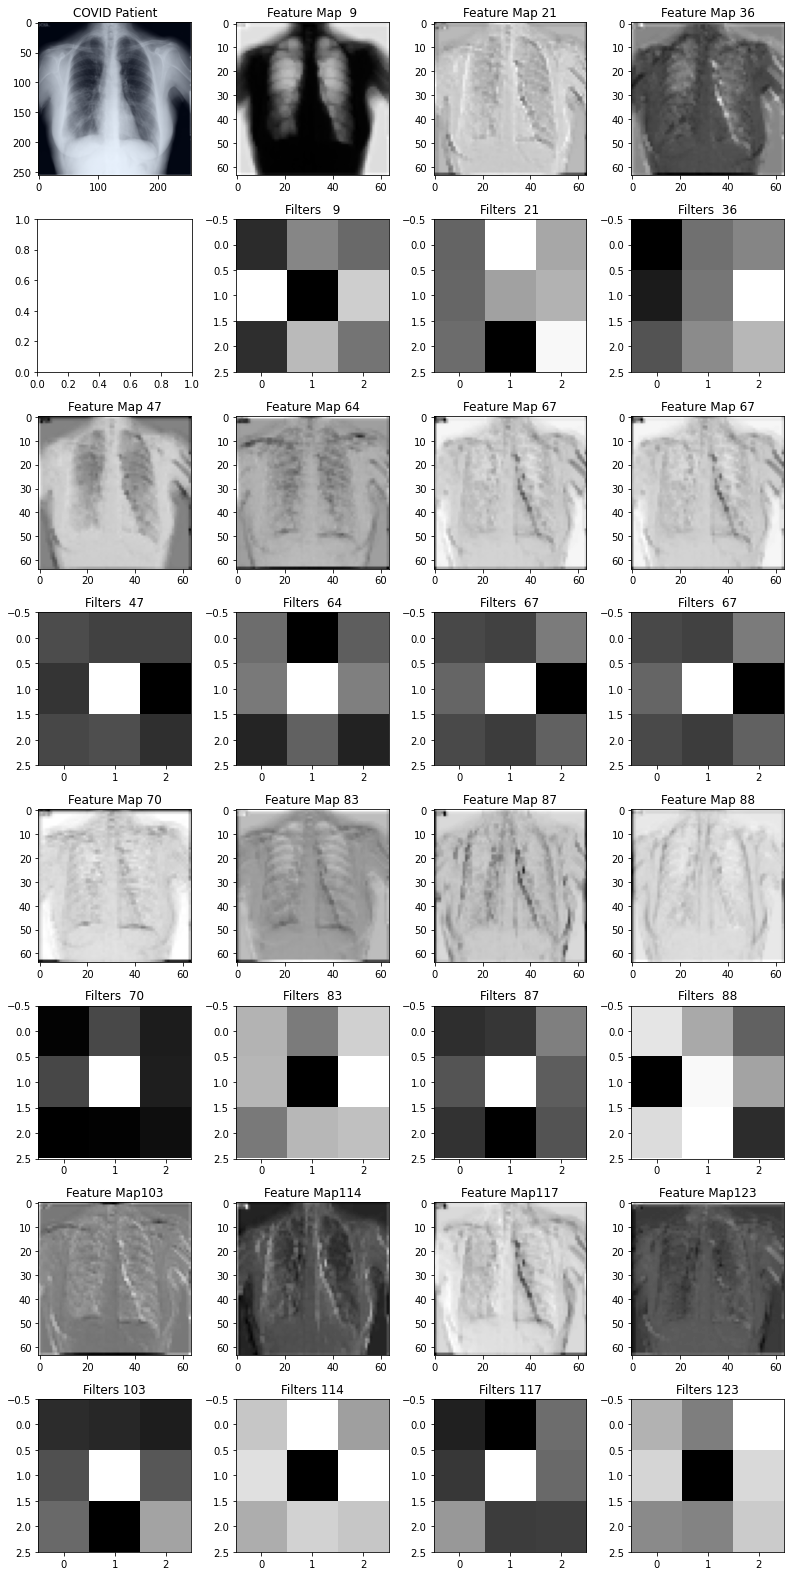

In [14]:
fig, ax = plt.subplots(8, 4, figsize=(11, 22))

# Normalize the tensor image with MinMax normalization before plotting
np_image = image.cpu().numpy()[0].transpose([1, 2, 0])
np_image -= np_image.min()
np_image /= np_image.max()

ax[0][0].set_title("{:s} Patient".format(data_xrays.classes[data_xrays.targets[index]]))
ax[0][0].imshow(np_image)

# Number of output features
num_features = x.shape[1]
# Randomly selected some feature outputs
select_indices = np.sort(np.random.choice(num_features, 15))

for i in range(0, 8, 2):
    for j in range(4):
        if i == 0 and j == 0:
            continue
        index = select_indices[i * 2 + j - 1]
        feature_map = x[0, index].cpu().numpy()
        feature_map -= feature_map.min()
        feature_map /= feature_map.max()
        ax[i][j].set_title("Feature Map{:3d}".format(index))
        ax[i][j].imshow(feature_map, cmap='gray')
        
        # Normalize the filter before plotting
        norm_filter = features_dense_blk_1[2, index]
        norm_filter -= norm_filter.min()
        norm_filter /= norm_filter.max()
        ax[i + 1][j].set_title("Filters {:3d}".format(index))
        ax[i + 1][j].imshow(norm_filter, cmap='gray')

plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.show()

### 33. Get the Output Feature Maps from Each Dense Block (Low-level to High-level features)

In [15]:
model.eval()
# use torch.device("cpu") if you don't want to use GPU
x = model.features.conv0(image.to(torch.device("cuda")))
x = model.features.norm0(x)
x = model.features.relu0(x)
x = model.features.pool0(x)

# Save the output from each dense block
denseblock_1 = model.features.denseblock1(x)
print("Dense Block 1 Output Shape:  " + str(denseblock_1.shape))

x = model.features.transition1(denseblock_1)
denseblock_2 = model.features.denseblock2(x)
print("Dense Block 2 Output Shape:  " + str(denseblock_2.shape))

x = model.features.transition2(denseblock_2)
denseblock_3 = model.features.denseblock3(x)
print("Dense Block 3 Output Shape:  " + str(denseblock_3.shape))

x = model.features.transition3(denseblock_3)
denseblock_4 = model.features.denseblock4(x)
print("Dense Block 4 Output Shape:  " + str(denseblock_4.shape))

Dense Block 1 Output Shape:  torch.Size([1, 256, 64, 64])
Dense Block 2 Output Shape:  torch.Size([1, 512, 32, 32])
Dense Block 3 Output Shape:  torch.Size([1, 1024, 16, 16])
Dense Block 4 Output Shape:  torch.Size([1, 1024, 8, 8])


### 34. Visualize the Output Feature Maps from Each Dense Block (Low-level to High-level features)
I plot the features map from the dense block 1 to 4 of the DenseNet 121. They are corresponding to the **low-level to the high-level** features of the input image. I scaled the number of plotted feature maps in a sense of dense block's output depths (however, it is not a linear scale). 

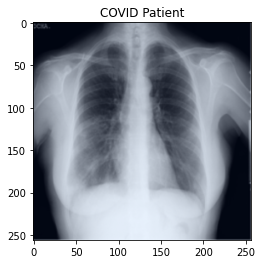

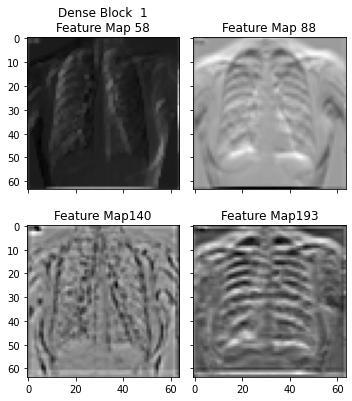

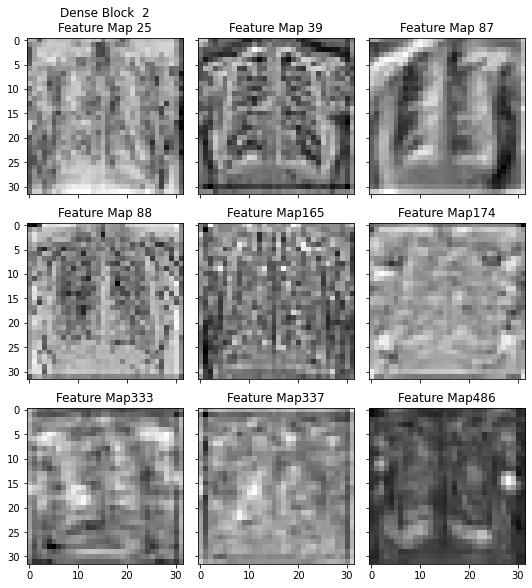

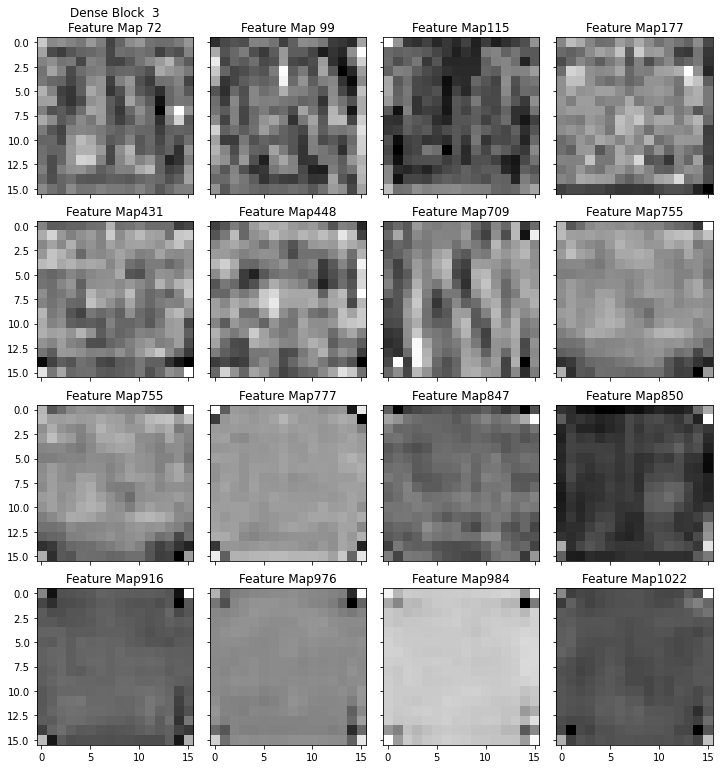

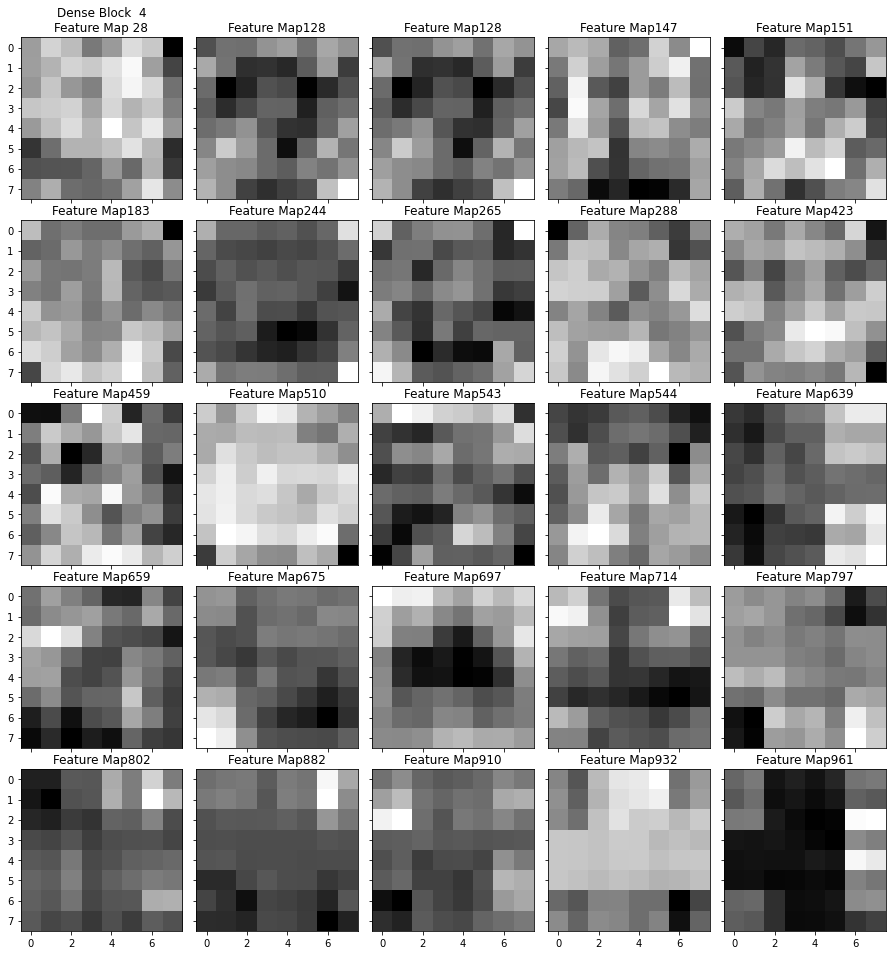

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True, sharex=True)

# Normalize the tensor image with MinMax normalization before plotting
np_image = image.cpu().numpy()[0].transpose([1, 2, 0])
np_image -= np_image.min()
np_image /= np_image.max()

ax.set_title("{:s} Patient".format(data_xrays.classes[data_xrays.targets[index]]))
ax.imshow(np_image)

# Iterate through the dense block outputs
ith_block = 1
for block_output in [denseblock_1, denseblock_2, denseblock_3, denseblock_4]:
    # Get the number of features in the output
    num_features = block_output.shape[1]
    selected_num = ith_block + 1
    # Randomly select a subset of features
    select_indices = np.sort(np.random.choice(num_features, selected_num ** 2))
    
    fig, ax = plt.subplots(selected_num, selected_num, figsize=(selected_num * 2.5, (selected_num + 0.3) * 2.5),
                           sharey=True, sharex=True)
    
    # Plot the feature maps
    for i in range(len(ax)):
        for j in range(len(ax[0])):
            index = select_indices[i * selected_num + j]
            feature_map = block_output[0, index].cpu().numpy()
            feature_map -= feature_map.min()
            feature_map /= feature_map.max()
            
            if i==0 and j==0:
                ax[i][j].set_title("Dense Block{:3d}\nFeature Map{:3d}".format(ith_block, index))
            else:
                ax[i][j].set_title("Feature Map{:3d}".format(index))
            ax[i][j].imshow(feature_map, cmap='gray')
    ith_block += 1
    
    plt.subplots_adjust(hspace=0.05)
    plt.tight_layout()
    plt.show()